## Auto Encoder 구현하기

**import package**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt
import random

**GPU/CPU setting**


1. 상단메뉴의 런타임 - 런타임 유형 변경 - 하드웨어 가속기 메뉴에서 GPU를 선택 - 저장

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda' :
  torch.cuda.manual_seed_all(777)

cuda


**데이터 불러오기**

Fashion MNIST 데이터

Labels : T-shirt/top, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, ankle boot

In [ ]:
fashion_train = datasets.FashionMNIST("../image_data/FashionMNIST", train=True, download=True, transform=transforms.ToTensor())
fashion_test = datasets.FashionMNIST("../image_data/FashionMNIST", train=False, download=True, transform=transforms.ToTensor())

# 데이터가 0~1의 범위를 가지도록 normalize
fashion_train.data = fashion_train.data/255.0
fashion_train.targets = fashion_train.targets
fashion_test.data = fashion_test.data/255.0
fashion_test.targets = fashion_test.targets

100%|██████████| 26421880/26421880 [00:07<00:00, 3333868.92it/s] 


Extracting ../image_data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../image_data/FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 300936.11it/s]


Extracting ../image_data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../image_data/FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5549689.69it/s]


Extracting ../image_data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../image_data/FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21484852.73it/s]


Extracting ../image_data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../image_data/FashionMNIST/FashionMNIST/raw



tensor(0)


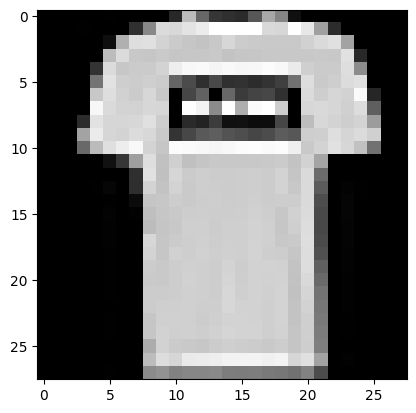

In [ ]:
plt.imshow(fashion_train.data[1], cmap="gray")
print(fashion_train.targets[1])

**데이터를 배치화하기**

In [ ]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(fashion_train.data, batch_size = batch_size, shuffle=True, drop_last=False)
test_loader = torch.utils.data.DataLoader(fashion_train.data, batch_size = len(fashion_test.data), shuffle=False, drop_last=False)

**Model 생성**

-- Hidden layer 수 : 2개

-- 활성화 함수 : Sigmoid


-- Optimization 기법 : Adam

In [ ]:
class Autoencoder(nn.Module) :
  def __init__(self) :
    super(Autoencoder, self).__init__()

    self.encoder1 = nn.Linear(784, 256)
    self.encoder2 = nn.Linear(256, 16)
    self.decoder1 = nn.Linear(16, 256)
    self.decoder2 = nn.Linear(256, 784)

  def forward(self, x) :
    z_vector = self.encoder1(x)
    z_vector = self.encoder2(z_vector)
    output = F.sigmoid(self.decoder1(z_vector))
    output = self.decoder2(output)

    return torch.sigmoid(output)

In [ ]:
model = Autoencoder().to(device)

In [ ]:
# 파라미터 정의 -> 반복횟수 10으로 설정 / learning_rate는 0.001로 설정

num_epochs = 10
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

**Train 과정**

In [ ]:
loss_list = []
for epoch_num in range(num_epochs) :
  average_cost = 0

  for batch_idx, images in enumerate(train_loader) :
    num_of_mini_batch = len(train_loader)

    images = images.to(device)
    input_image = images.reshape(-1, 28*28)
    optimizer.zero_grad()
    y_predict = model(input_image)
    loss = criterion(y_predict, input_image)
    loss.backward()
    optimizer.step()

    average_cost = average_cost + (loss.item()/num_of_mini_batch)
    loss_list.append(loss)

  print("Epoch {} Loss {:.5f}".format((epoch_num+1), average_cost))

Epoch 1 Loss 0.03440
Epoch 2 Loss 0.01952
Epoch 3 Loss 0.01697
Epoch 4 Loss 0.01561
Epoch 5 Loss 0.01477
Epoch 6 Loss 0.01424
Epoch 7 Loss 0.01385
Epoch 8 Loss 0.01356
Epoch 9 Loss 0.01332
Epoch 10 Loss 0.01316


**Validation 과정**

In [ ]:
for batch_idx, image in enumerate(test_loader) :
  with torch.no_grad() :
    test_image = image.reshape(-1, 28*28).to(device)
    test_recon_x = model(test_image)

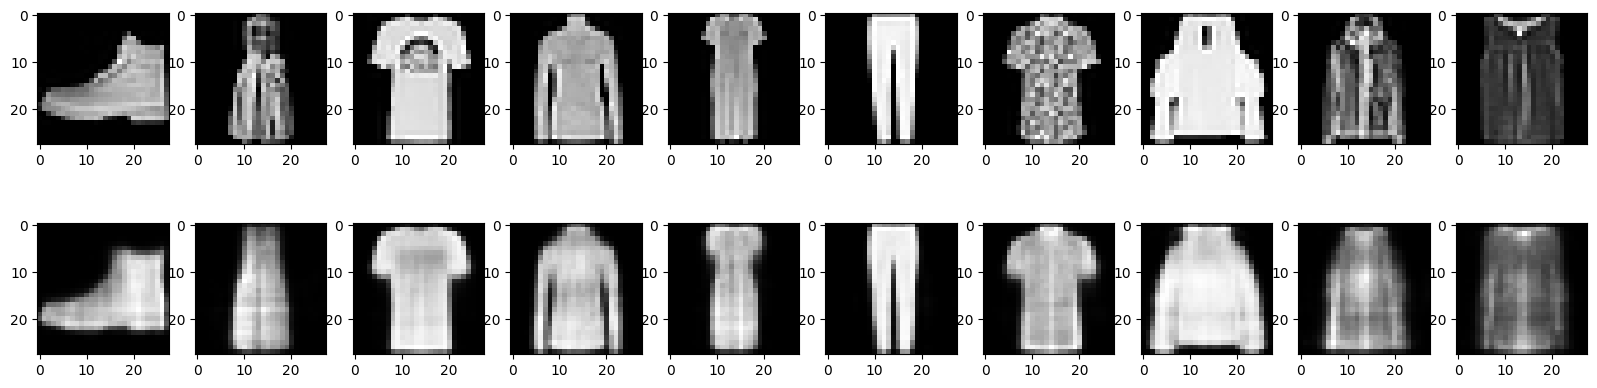

In [ ]:
n=10 # 10개씩 비교
plt.figure(figsize=(20,5))

for i in range(n):
  ax = plt.subplot(2, 10, i+1)
  test_img = image[i*100].to(device)
  plt.imshow(test_img.cpu(), cmap="gray")

  ax = plt.subplot(2, 10, i+1+n)
  recon_image = test_recon_x.data[i*100].reshape(28,28)
  plt.imshow(recon_image.cpu(), cmap='gray')

## Variational Auto Encoder 구현하기

**데이터 불러오기**

Fashion MNIST 데이터

Labels : T-shirt/top, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, ankle boot

In [ ]:
fashion_train = datasets.FashionMNIST("../image_data/FashionMNIST", train=True, download=True, transform=transforms.ToTensor())
fashion_test = datasets.FashionMNIST("../image_data/FashionMNIST", train=False, download=True, transform=transforms.ToTensor())

# 데이터가 0~1의 범위를 가지도록 normalize
fashion_train.data = fashion_train.data/255.0
fashion_train.targets = fashion_train.targets
fashion_test.data = fashion_test.data/255.0
fashion_test.targets = fashion_test.targets

tensor(0)


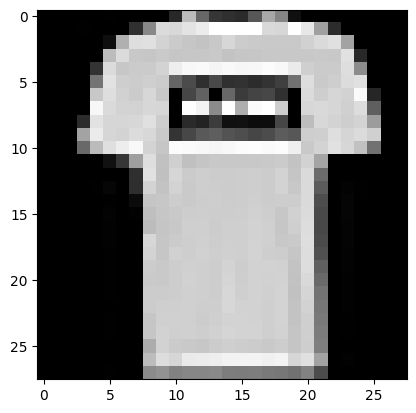

In [ ]:
plt.imshow(fashion_train.data[1], cmap="gray")
print(fashion_train.targets[1])

**데이터를 배치화하기**

In [ ]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(fashion_train.data, batch_size = batch_size, shuffle=True, drop_last=False)
test_loader = torch.utils.data.DataLoader(fashion_train.data, batch_size = len(fashion_test.data), shuffle=False, drop_last=False)

**Model 생성**

-- Hidden layer 수 : 2개

-- 평균(mu)과 분산(logvar) 추정

-- 활성화 함수 : Sigmoid


-- Optimization 기법 : Adam

In [ ]:
class VAE(nn.Module) :
  def __init__(self) :
    super(VAE, self).__init__()

    self.fc1 = nn.Linear(784, 256)
    self.mu = nn.Linear(256, 20)
    self.logvar = nn.Linear(256, 20)
    self.fc2 = nn.Linear(20, 256)
    self.fc3 = nn.Linear(256, 784)

  def encode(self, x) :
    h1 = F.relu(self.fc1(x))
    mu = self.mu(h1)
    logvar = self.logvar(h1)

    return mu, logvar

  def reparameterize(self, mu_vector, logvar_vector) :
    var_vector = torch.exp(logvar_vector)  # logvar -> var 변환
    std = torch.sqrt(var_vector)  # 표준편차
    eps = torch.randn_like(std)  # 표준편차를 가지는 랜덤한 값
    z_vector = mu_vector + eps.mul(std)

    return z_vector

  def decode(self, z) :
    h2 = F.relu(self.fc2(z))
    Bernouhlli_p = torch.sigmoid(self.fc3(h2))

    return Bernouhlli_p

  def forward(self, x) :
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    Bernouhlli_p = self.decode(z)

    return Bernouhlli_p, mu, logvar

In [ ]:
model = VAE().to(device)

In [ ]:
# 손실함수를 정의

def loss_function(recon_x, x, mu, logvar) :
  Bernouhlli_loss = F.binary_cross_entropy(recon_x, x.reshape(-1, 784), reduction='sum')
  KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return Bernouhlli_loss + KL_divergence

In [ ]:
# 파라미터 정의 -> 반복횟수 10으로 설정 / learning_rate는 0.001로 설정

num_epochs = 10
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

**Train 과정**

In [ ]:
loss_list = []
for epoch_num in range(num_epochs) :
  average_cost = 0

  for batch_idx, images in enumerate(train_loader) :
    num_of_mini_batch = len(train_loader)

    images = images.to(device)
    input_image = images.reshape(-1, 28*28)
    optimizer.zero_grad()
    recon_x, mu, logvar = model(input_image)
    loss = loss_function(recon_x, input_image, mu, logvar)
    loss.backward()
    optimizer.step()

    average_cost = average_cost + (loss.item()/num_of_mini_batch)
    loss_list.append(loss)

  print("Epoch {} Loss {:.5f}".format((epoch_num+1), average_cost))

Epoch 1 Loss 28536.58597
Epoch 2 Loss 25687.79709
Epoch 3 Loss 25126.13497
Epoch 4 Loss 24837.89088
Epoch 5 Loss 24673.61923
Epoch 6 Loss 24558.36481
Epoch 7 Loss 24488.16451
Epoch 8 Loss 24422.60073
Epoch 9 Loss 24373.53132
Epoch 10 Loss 24332.92402


**Validation 과정**

In [ ]:
for batch_idx, image in enumerate(test_loader) :
  with torch.no_grad() :
    test_image = image.reshape(-1, 28*28).to(device)
    test_recon_x, _, _ = model(test_image)

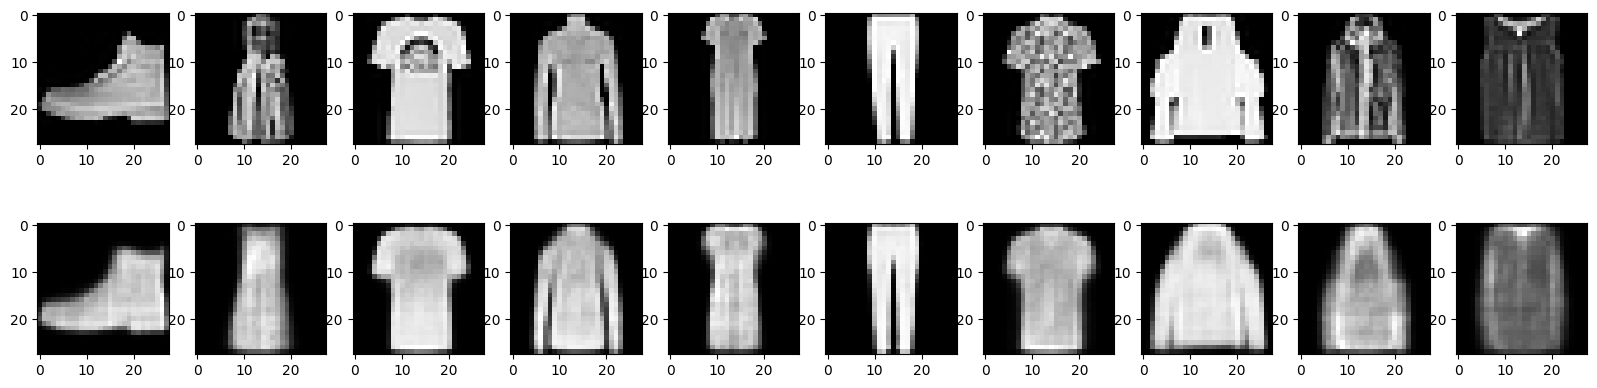

In [ ]:
n=10 # 10개씩 비교
plt.figure(figsize=(20,5))

for i in range(n):
  ax = plt.subplot(2, 10, i+1)
  test_img = image[i*100].to(device)
  plt.imshow(test_img.cpu(), cmap="gray")

  ax = plt.subplot(2, 10, i+1+n)
  recon_image = test_recon_x.data[i*100].reshape(28,28)
  plt.imshow(recon_image.cpu(), cmap='gray')

**학습된 Decoder만으로 새로운 데이터를 생성 가능**

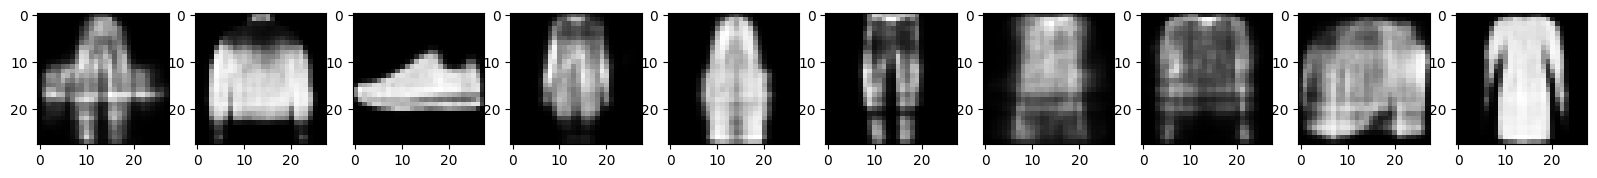

In [ ]:
plt.figure(figsize=(20,5))
for i in range(10) :
  ax = plt.subplot(2, 10, i + 1)
  with torch.no_grad() :
    sample_z = torch.randn(20).to(device)
    input_z = sample_z
    sample = model.decode(input_z).cpu()
    plt.imshow(sample.reshape(28,28), cmap='gray')